# Final project CIFAR10
-- Network used VGG16

- **Pretrained VGG model (using weights of imageNet)**

Student Name/ID : Aloukik aditya(115290) , Sarthak Rawat(1101124)
 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,concatenate,Activation
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.datasets import cifar10
import timeit
import cv2
import gc
import random
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import LearningRateScheduler

print("Setup Done..")

Setup Done..


## Loading test and train data 
- We use cifar10.load_data() to load our data

In [2]:
(train_imgs, train_labels), (test_imgs, test_labels) = cifar10.load_data()
print("Data loaded")

Data loaded


## Checking data shape and size

In [3]:
print("Shape of train data: ",train_imgs.shape)
print("Shape of test data: ",test_imgs.shape)
print("Shape of train labels: ",train_labels.shape)
print("Shape of test labels: ",test_labels.shape)

Shape of train data:  (50000, 32, 32, 3)
Shape of test data:  (10000, 32, 32, 3)
Shape of train labels:  (50000, 1)
Shape of test labels:  (10000, 1)


## Plotting some random images

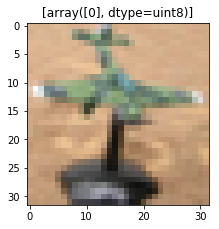

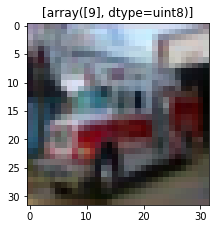

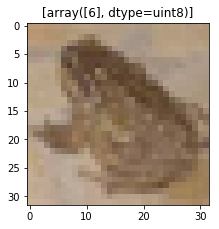

In [4]:
val_index = []
for i in range(3):
    value = random.randint(0,3582)
    val_index.append(value)
    plt.figure( figsize=(15, 15))
    plt.subplot(1, 4, i+1)
    plt.title([train_labels[value]])
    plt.imshow(train_imgs[value])

plt.show()

# Preprocess image using VGG function image
- The function is used to normalize image according to VGG16 network

In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input 
start = timeit.default_timer()
train_imgs = preprocess_input(train_imgs)
test_imgs = preprocess_input(test_imgs)
stop = timeit.default_timer()
print('Time taken to preprocess/normalize data : ', stop - start)

Time taken to preprocess/normalize data :  0.36648229499996887


## Resize test and train images
- The images are resized to (224,244,3) format so that they can be used with VGG model
- The below code takes up lot of RAM so be sure to increase your ram on google cloud (otherwise you may get memory error)

In [6]:
gc.collect()
start = timeit.default_timer()
train_imgs = np.array([cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC) for img in train_imgs])
test_imgs = np.array([cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC) for img in test_imgs])
stop = timeit.default_timer()
print('Time taken to resize data : ', stop - start)
print("Resize done")

Time taken to resize data :  32.71071387899974
Resize done


In [7]:
#check shape of newly resiezed image
train_imgs.shape

(50000, 224, 224, 3)

## Applying one hot encoding on our labels

In [8]:
onehot_encoder = OneHotEncoder(sparse=False)

train_labels = train_labels.reshape(-1,1)
test_labels = test_labels.reshape(-1,1)

train_labels = onehot_encoder.fit_transform(train_labels)
test_labels = onehot_encoder.transform(test_labels)


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [9]:
print("Shape of train labels: ",train_labels.shape)
print("Shape of test labels: ",test_labels.shape)

Shape of train labels:  (50000, 10)
Shape of test labels:  (10000, 10)



## Using model from keras--> VGG16
- we have used pretrained weights for imagenet and kept the top fully connected layers.

## How we train our model:
- we freeze our layers of VGG16 so that they are not trained initially
- we only train our new Fully connected layers (so that they start extracting meanings from VGG16 network)
- we only use 2 epochs with high learning rate
- we then unfreeze VGG16 layers, and then train our model with a low variable learning rate for higher number of epoch.

### Fully connected layers(Description):
- We use 2 fully connected layers and then add a drop out layer in between to reduce overfitting.
- We also add Reguralizer to prevent overfitting
- we have used Adam optimizer with learning rate of 0.0001 for training FC layers for 2 epochs
- for later traning of full model w ehave used variable Learning rates


### Freezing VGG16 layers
- we freeze vgg16 model for our first 2 epoch (only new fully connected layer is trained)
- after these epoch we unfreeze the model and train it

In [10]:
#define variable learning rates

def learning_rate_schedule(epoch):
    if epoch <= 3:
        return 1e-4 # 0.00001
    elif epoch <= 8:
        return 1e-5
    elif epoch <= 10:
        return 1e-6
    else:
        return 1e-7
    return LR

In [11]:
#Initilize vgg net
vgg_net = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))

#Define our model 
x = vgg_net.get_layer('fc2').output
x = Dense(800, activity_regularizer=l1(0.001),activation='relu', name='my_fc3')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax', name='predictions')(x)
model_updated = Model(inputs=vgg_net.input, outputs=x)


## save our model weights
model_updated.save_weights('CIFAR10_VGG16_model_updated_initial.h5')
print("Model_Updated saved")

history_fc_list = []
history_full_list = []


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model_Updated saved


In [12]:
# Function to free up keras memory

from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow 

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    

Using TensorFlow backend.


## Run 1

In [13]:

i=0
#Initilize vgg net
vgg_net = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))

#Define our model 
x = vgg_net.get_layer('fc2').output
x = Dense(800, activity_regularizer=l1(0.001),activation='relu', name='my_fc3')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax', name='predictions')(x)
model_updated = Model(inputs=vgg_net.input, outputs=x)

gc.collect()


model_updated.load_weights('CIFAR10_VGG16_model_updated_initial.h5')

print('------------------------New run started---------------------------------')
print('Initial model weights loaded , Started training run number ', i+1)
print('------------------------------------------------------------------------')

# Make the last Fully connected layers trainable and freezing the rest of VGG model
for layer in model_updated.layers:
    layer.trainable = False
for layer in model_updated.layers[-3:]:
    layer.trainable = True

tensorboard = TensorBoard(log_dir="logs\{}".format('CIFAR10\FC_Layer'+str(i)))

model_updated.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])


print('--------------------------Starting Fully connected layer training------------------------------------')

history_fc = model_updated.fit(train_imgs, train_labels, batch_size=128,\
shuffle=True, epochs=2, validation_data=\
                    (test_imgs, test_labels),callbacks =[tensorboard])


gc.collect()
##Unfreeze weights ------ Now full model will be trained
for layer in model_updated.layers:
    layer.trainable = True


no_epochs = 10
tensorboard = TensorBoard(log_dir="logs\{}".format('CIFAR10\FULL_Model'+str(i)))

opt2 = optimizers.Adam(lr=0.00001)

### Variable learning rate -----------------------
lrate = LearningRateScheduler(learning_rate_schedule)
callbacks_list = [lrate,tensorboard]




model_updated.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])


print('--------------------------Starting Full model training -->after unfreez------------------------------------')

## Training full model 
history = model_updated.fit(train_imgs, train_labels, batch_size=128,\
shuffle=True, epochs=no_epochs, validation_data=\
                    (test_imgs, test_labels),callbacks =callbacks_list)



## Timer for checking time taken
stop = timeit.default_timer()
print('Time taken for one run is : ', stop - start)

model_updated.save_weights('CIFAR10_VGG16_model_updated_fin.h5')
print("Model_Updated weights saved") 

## saving history for plots
history_fc_list.append(history_fc)
history_full_list.append(history)

------------------------New run started---------------------------------
Initial model weights loaded , Started training run number  1
------------------------------------------------------------------------
--------------------------Starting Fully connected layer training------------------------------------
Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 151s 3ms/sample - loss: 0.7550 - acc: 0.8080 - val_loss: 0.5674 - val_acc: 0.8551
Epoch 2/2
50000/50000 [==============================] - 149s 3ms/sample - loss: 0.5196 - acc: 0.8671 - val_loss: 0.5162 - val_acc: 0.8637
--------------------------Starting Full model training -->after unfreez------------------------------------
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 374s 7ms/sample - loss: 1.1199 - acc: 0.6352 - val_loss: 0.6530 - val_acc: 0.8055
Epoch 2/10
50000/50000 [==============================] - 368s 7

## Run 2

In [14]:
reset_keras()
i=1
#Initilize vgg net
vgg_net = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))

#Define our model 
x = vgg_net.get_layer('fc2').output
x = Dense(800, activity_regularizer=l1(0.001),activation='relu', name='my_fc3')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax', name='predictions')(x)
model_updated = Model(inputs=vgg_net.input, outputs=x)

gc.collect()


model_updated.load_weights('CIFAR10_VGG16_model_updated_initial.h5')

print('------------------------New run started---------------------------------')
print('Initial model weights loaded , Started training run number ', i+1)
print('------------------------------------------------------------------------')

# Make the last Fully connected layers trainable and freezing the rest of VGG model
for layer in model_updated.layers:
    layer.trainable = False
for layer in model_updated.layers[-3:]:
    layer.trainable = True

tensorboard = TensorBoard(log_dir="logs\{}".format('CIFAR10\FC_Layer'+str(i)))

model_updated.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])


print('--------------------------Starting Fully connected layer training------------------------------------')

history_fc = model_updated.fit(train_imgs, train_labels, batch_size=128,\
shuffle=True, epochs=2, validation_data=\
                    (test_imgs, test_labels),callbacks =[tensorboard])


gc.collect()
##Unfreeze weights ------ Now full model will be trained
for layer in model_updated.layers:
    layer.trainable = True


no_epochs = 6
tensorboard = TensorBoard(log_dir="logs\{}".format('CIFAR10\FULL_Model'+str(i)))

opt2 = optimizers.Adam(lr=0.00001)

### Variable learning rate -----------------------
lrate = LearningRateScheduler(learning_rate_schedule)
callbacks_list = [lrate,tensorboard]




model_updated.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])


print('--------------------------Starting Full model training -->after unfreez------------------------------------')

## Training full model 
history = model_updated.fit(train_imgs, train_labels, batch_size=128,\
shuffle=True, epochs=no_epochs, validation_data=\
                    (test_imgs, test_labels),callbacks =callbacks_list)



## Timer for checking time taken
stop = timeit.default_timer()
print('Time taken for one run is : ', stop - start)

model_updated.save_weights('CIFAR10_VGG16_model_updated_fin.h5')
print("Model_Updated weights saved") 

## saving history for plots
history_fc_list.append(history_fc)
history_full_list.append(history)

14
------------------------New run started---------------------------------
Initial model weights loaded , Started training run number  2
------------------------------------------------------------------------
--------------------------Starting Fully connected layer training------------------------------------
Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 149s 3ms/sample - loss: 0.7490 - acc: 0.8070 - val_loss: 0.5700 - val_acc: 0.8523
Epoch 2/2
50000/50000 [==============================] - 148s 3ms/sample - loss: 0.5185 - acc: 0.8695 - val_loss: 0.5103 - val_acc: 0.8679
--------------------------Starting Full model training -->after unfreez------------------------------------
Train on 50000 samples, validate on 10000 samples
Epoch 1/6
50000/50000 [==============================] - 368s 7ms/sample - loss: 0.5692 - acc: 0.8474 - val_loss: 0.3907 - val_acc: 0.8960
Epoch 2/6
50000/50000 [==============================] - 368s 

## Run 3

In [15]:
reset_keras()
i=2
#Initilize vgg net
vgg_net = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))

#Define our model 
x = vgg_net.get_layer('fc2').output
x = Dense(800, activity_regularizer=l1(0.001),activation='relu', name='my_fc3')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax', name='predictions')(x)
model_updated = Model(inputs=vgg_net.input, outputs=x)

gc.collect()


model_updated.load_weights('CIFAR10_VGG16_model_updated_initial.h5')

print('------------------------New run started---------------------------------')
print('Initial model weights loaded , Started training run number ', i+1)
print('------------------------------------------------------------------------')

# Make the last Fully connected layers trainable and freezing the rest of VGG model
for layer in model_updated.layers:
    layer.trainable = False
for layer in model_updated.layers[-3:]:
    layer.trainable = True

tensorboard = TensorBoard(log_dir="logs\{}".format('CIFAR10\FC_Layer'+str(i)))

model_updated.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])


print('--------------------------Starting Fully connected layer training------------------------------------')

history_fc = model_updated.fit(train_imgs, train_labels, batch_size=128,\
shuffle=True, epochs=2, validation_data=\
                    (test_imgs, test_labels),callbacks =[tensorboard])


gc.collect()
##Unfreeze weights ------ Now full model will be trained
for layer in model_updated.layers:
    layer.trainable = True


no_epochs = 6
tensorboard = TensorBoard(log_dir="logs\{}".format('CIFAR10\FULL_Model'+str(i)))

opt2 = optimizers.Adam(lr=0.00001)

### Variable learning rate -----------------------
lrate = LearningRateScheduler(learning_rate_schedule)
callbacks_list = [lrate,tensorboard]




model_updated.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])


print('--------------------------Starting Full model training -->after unfreez------------------------------------')

## Training full model 
history = model_updated.fit(train_imgs, train_labels, batch_size=128,\
shuffle=True, epochs=no_epochs, validation_data=\
                    (test_imgs, test_labels),callbacks =callbacks_list)



## Timer for checking time taken
stop = timeit.default_timer()
print('Time taken for one run is : ', stop - start)

model_updated.save_weights('CIFAR10_VGG16_model_updated_fin.h5')
print("Model_Updated weights saved") 

## saving history for plots
history_fc_list.append(history_fc)
history_full_list.append(history)

14
------------------------New run started---------------------------------
Initial model weights loaded , Started training run number  3
------------------------------------------------------------------------
--------------------------Starting Fully connected layer training------------------------------------
Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 149s 3ms/sample - loss: 0.7550 - acc: 0.8069 - val_loss: 0.5655 - val_acc: 0.8548
Epoch 2/2
50000/50000 [==============================] - 148s 3ms/sample - loss: 0.5190 - acc: 0.8692 - val_loss: 0.5193 - val_acc: 0.8618
--------------------------Starting Full model training -->after unfreez------------------------------------
Train on 50000 samples, validate on 10000 samples
Epoch 1/6
50000/50000 [==============================] - 368s 7ms/sample - loss: 0.8782 - acc: 0.7236 - val_loss: 0.4848 - val_acc: 0.8644
Epoch 2/6
50000/50000 [==============================] - 368s 

## Tensorboard logs have been save to logs folder
- where "*\FC_Layer" folder means logs where we train only our FC layers
- where "*\FULL_Model" folder means logs where we train all layers in our model

## Plotting the graphs of testing accuracy 
- Test accuracy
- Plotted for only FC_layer training
- Plotted for full model training


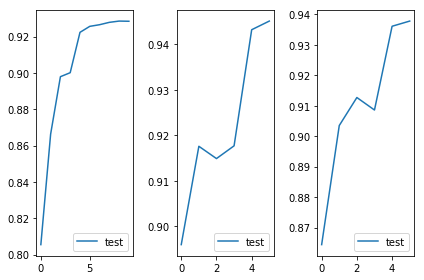

Average testing accuracy: 0.9370999932289124


In [16]:
plt.subplot(1, 3, 1)
plt.plot(history_full_list[0].history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history_full_list[1].history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(1, 3, 3)
plt.plot(history_full_list[2].history['val_acc'])
plt.legend(['test'], loc='lower right')
plt.tight_layout() 

plt.show()

avg_train_acc = 0
avg_test_acc = 0
final_train_loss = []
final_test_loss = []

for his in history_full_list:
    final_train_loss.append(his.history['loss'][-1])
    final_test_loss.append(his.history['val_loss'][-1])
    avg_train_acc = avg_train_acc + his.history['acc'][-1]
    avg_test_acc = avg_test_acc + his.history['val_acc'][-1]

avg_train_acc = avg_train_acc/len(history_fc_list)
avg_test_acc = avg_test_acc/len(history_fc_list)


print("Average testing accuracy: {}".format(avg_test_acc))

## Train acc vs Test acc

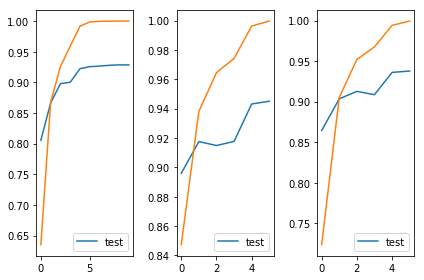

Average train accuracy: 0.9996999899546305


In [17]:
plt.subplot(1, 3, 1)
plt.plot(history_full_list[0].history['val_acc'])
plt.plot(history_full_list[0].history['acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history_full_list[1].history['val_acc'])
plt.plot(history_full_list[1].history['acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(1, 3, 3)
plt.plot(history_full_list[2].history['val_acc'])
plt.plot(history_full_list[2].history['acc'])
plt.legend(['test'], loc='lower right')
plt.tight_layout() 

plt.show()
print("Average train accuracy: {}".format(avg_train_acc))

# Final model accuracy is :

In [18]:
print("Average Model Train accuracy is  : ",avg_test_acc*100,"%")

Average Model Train accuracy is  :  93.70999932289124 %


### Model structure is saved to an image.

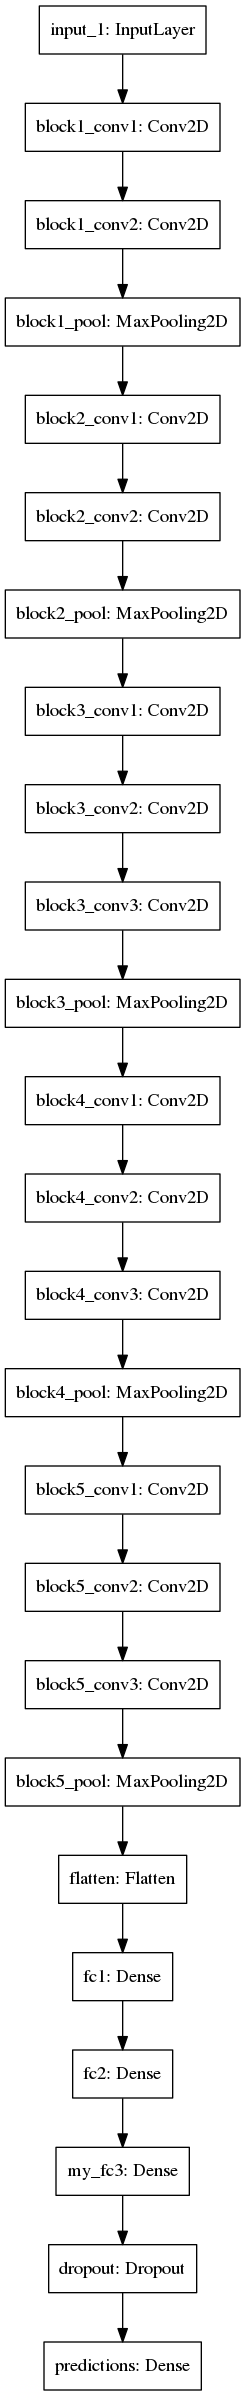

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model_updated, to_file='model_CIFAR10_VGG16.png')

#### Thank you 